In [1]:
# import library
from math import cos
import numpy as np
import pandas as pd
import random as rd
import torch
import torch.nn as nn
from torch_scatter import scatter
from torch_geometric.nn import MessagePassing
from torchmetrics import R2Score
from tqdm import tqdm
import matplotlib.pyplot as plt

print('Library Importing Sucess!')

Library Importing Sucess!


In [2]:
# define feynman diagram class

class feynmanGraph:
    def __init__(self,num_nodes:int, num_edges:int, amplitude=1):
        self.num_nodes = num_nodes
        self.num_edges = num_edges
        self.nodes_feat = []
        self.edges_feat = []
        self.amplitude = amplitude
        #self.proc_type = process_type

    def add_adj(self,adj):
        self.adjacency = adj

    def add_nodes(self, nodes_feat):
        """ 
        shape of nodes_feat = [num_nodes, num_node_feat] = [5,7]
        node_feat: [mass, charge, spin, erengy, momentum, angular direction,type]
        node_type: +-1 for external legs, 0 for propagators
        """
        self.nodes_feat = nodes_feat

    def add_edges(self, edges_feat):
        self.edges_feat = edges_feat

    def add_amp(self, amp):
        self.amplitude = amp

    def get_node(self):
        return self.nodes_feat

    def get_edge(self):
        return self.edges_feat

    def get_amp(self):
        return self.amplitude

    #def get_process_type(self):
        #return self.proc_type

print('Feynman Graph Sucess!')

Feynman Graph Sucess!


In [414]:
# define each process and related list

# num_edge_feat=2, first feat: -1 for fermion-fermion , 1 for fermion-photon; second feat: numbers of activate

# four process: pair annihilation, Bhabha scattering, Møller scattering, Columb Scattering

mass = {'electron': 0.51099895, 'muon': 105.6583755, 'photon':0}

def PairAnnihilation(Ecm, in_particle:str, out_particle:str, out_ang):
    graph = feynmanGraph(num_nodes=5, num_edges=15, amplitude=0)
    edge_feat = torch.tensor(
        [[-1,1],[1,1],[1,1],[1,1],[1,1],[-1,1]],dtype=torch.float
    )
    E_in, E_out = Ecm/2, Ecm/2
    p_in, p_out = (E_in**2 - mass[in_particle]**2)**0.5, (E_out**2 - mass[out_particle]**2)**0.5
    amp = (2 * E_in**4 + 2 * E_in**2 * (E_in**2 - mass[out_particle]**2) * cos(out_ang)**2 + 2 * mass[out_particle]**2 * E_in**2) / (2 * E_in**4)
    node_feat = torch.tensor(
        [
            [mass[in_particle], -1, 1/2, E_in, p_in, 0,-1], 
            [mass[in_particle], 1, 1/2, E_in, p_in, np.pi,-1], 
            [mass['photon'], 0, 1, Ecm, 0, 0,0],
            [mass[out_particle], -1, 1/2, E_out, p_out, out_ang,1],
            [mass[out_particle], 1, 1/2, E_out, p_out, np.pi+out_ang,1]
        ]
        ,dtype=torch.float)
    graph.add_nodes(node_feat)
    graph.add_edges(edge_feat)
    graph.add_amp(amp)
    return graph

def BhabhaScattering(Ecm, in_particle:str, out_ang):
    graph = feynmanGraph(num_nodes=5, num_edges=15, amplitude=0)
    edge_feat = torch.tensor(
        [[-1,1],[1,2],[-1,1],[1,2],[-1,1],[1,2],[1,2],[-1,1]],dtype=torch.float
    )
    E_in, E_out = Ecm/2, Ecm/2
    p_in = (E_in**2 - mass[in_particle]**2)**0.5
    p_out = p_in
    s = Ecm**2
    t=-2*p_in**2*(1-cos(out_ang))
    u=-2*p_in**2*(1+cos(out_ang))
    amp = 2*((s**2+u**2)/(t**2)+2*(u**2)/(s*t)+(u**2+t**2)/(s**2))
    node_feat = torch.tensor(
            [
                [mass[in_particle], -1, 1/2, E_in, p_in, 0,-1], 
                [mass[in_particle], 1, 1/2, E_in, p_in, np.pi,-1], 
                [mass['photon'], 0, 1, Ecm, 0, 0,0],
                [mass[in_particle], -1, 1/2, E_out, p_out, out_ang,1],
                [mass[in_particle], 1, 1/2, E_out, p_out, np.pi+out_ang,1]
            ]
        ,dtype=torch.float)
    graph.add_nodes(node_feat)
    graph.add_edges(edge_feat)
    graph.add_amp(amp)
    return graph

def MøllerScattering(Ecm, in_particle:str, charge:int, out_ang):
    graph = feynmanGraph(num_nodes=5, num_edges=15, amplitude=0)
    edge_feat = torch.tensor(
        [[1,2],[-1,1],[-1,1],[1,2],[-1,1],[-1,1],[1,2],[1,2]],dtype=torch.float
    )
    E_in, E_out = Ecm/2, Ecm/2
    p_in = (E_in**2 - mass[in_particle]**2)**0.5
    p_out = p_in
    s = Ecm**2
    t = -2*p_in**2*(1-cos(out_ang))
    u = -2*p_in**2*(1+cos(out_ang))
    amp = 2/(t*u)*(s**2-8*mass[in_particle]**2*s+12*mass[in_particle]**4)
    node_feat = torch.tensor(
            [
                [mass[in_particle], charge, 1/2, E_in, p_in, 0,-1], 
                [mass[in_particle], charge, 1/2, E_in, p_in, np.pi,-1], 
                [mass['photon'], 0, 1, Ecm, 0, 0,0],
                [mass[in_particle], charge, 1/2, E_out, p_out, out_ang,1],
                [mass[in_particle], charge, 1/2, E_out, p_out, np.pi+out_ang,1]
            ]
        ,dtype=torch.float)
    graph.add_nodes(node_feat)
    graph.add_edges(edge_feat)
    graph.add_amp(amp)
    return graph

def ColumbScattering(Ecm, charge:int, out_ang):
    graph = feynmanGraph(num_nodes=5, num_edges=15, amplitude=0)
    edge_feat = torch.tensor(
        [[1,1],[-1,1],[1,1],[-1,1],[1,1],[-1,1]],dtype=torch.float
    )
    E_e = (Ecm**2+mass['electron']**2-mass['muon']**2)/(2*Ecm)
    E_mu = (Ecm**2-mass['electron']**2+mass['muon']**2)/(2*Ecm)
    p = (E_e**2-mass['electron']**2)**0.5
    be = (1-4*mass['electron']**2/Ecm**2)**0.5
    bmu = (1-4*mass['muon']**2/Ecm**2)**0.5
    amp = 1+be**2*bmu**2*cos(out_ang)**2+4*(mass['electron']**2+mass['muon']**2)/(Ecm**2)
    node_feat = torch.tensor(
            [
                [mass['electron'], charge, 1/2, E_e, p, 0,-1], 
                [mass['muon'], charge, 1/2, E_mu, p, np.pi,-1], 
                [mass['photon'], 0, 1, Ecm, 0, 0,0],
                [mass['electron'], charge, 1/2, E_e, p, out_ang,1],
                [mass['electron'], charge, 1/2, E_mu, p, np.pi+out_ang,1]
            ]
        ,dtype=torch.float)
    graph.add_nodes(node_feat)
    graph.add_edges(edge_feat)
    graph.add_amp(amp)
    return graph

print('Physics Process Definition Sucess!')

Physics Process Definition Sucess!


In [415]:
# dataset setup
proc_list = ['PairAnnihilation', 'BhabhaScattering', 'MøllerScattering', 'ColumbScattering']



#train_seed = 2024522
#test_seed = 3192003
#validate_sedd = 12345678

def normalization(data):
    Max = max(data)
    Min = min(data)
    new = []
    for i in range(len(data)):
        new.append((data[i]-Min)/(Max-Min))
    return Max,Min,new

def dataSETUP(size=1000):
    dataset = {'node_feat':[[],[],[],[]], 'edge_feat':[[],[],[],[]], 'amp':[[],[],[],[]]}
    for i in range(size):
        Ecm = 1600*np.random.random()+400
        ang = np.random.random()*4
        graph = PairAnnihilation(Ecm, 'electron', 'muon', ang)
        dataset['node_feat'][0].append(graph.get_node())
        dataset['edge_feat'][0].append(graph.get_edge())
        dataset['amp'][0].append(graph.get_amp())
########################################################################
        Ecm = 1600*np.random.random()+400
        ang = np.random.random()*4
        graph = PairAnnihilation(Ecm, 'muon', 'electron', ang)
        dataset['node_feat'][0].append(graph.get_node())
        dataset['edge_feat'][0].append(graph.get_edge())
        dataset['amp'][0].append(graph.get_amp())
########################################################################
        Ecm = 1600*np.random.random()+400
        ang = 1+2*np.random.random()
        graph = BhabhaScattering(Ecm, 'electron', ang)
        dataset['node_feat'][1].append(graph.get_node())
        dataset['edge_feat'][1].append(graph.get_edge())
        dataset['amp'][1].append(graph.get_amp())
########################################################################
        Ecm = 1600*np.random.random()+400
        ang = 1+2*np.random.random()
        graph = BhabhaScattering(Ecm, 'muon', ang)
        dataset['node_feat'][1].append(graph.get_node())
        dataset['edge_feat'][1].append(graph.get_edge())
        dataset['amp'][1].append(graph.get_amp())
########################################################################
        Ecm = 1600*np.random.random()+400
        ang = 1+2*np.random.random()
        graph = MøllerScattering(Ecm, 'electron',-1, ang)
        dataset['node_feat'][2].append(graph.get_node())
        dataset['edge_feat'][2].append(graph.get_edge())
        dataset['amp'][2].append(graph.get_amp())
########################################################################
        #Ecm = 1600*np.random.random()+400
        #ang = 2+np.random.random()
        #graph = MøllerScattering(Ecm, 'electron', 1,ang)
        #dataset['node_feat'][2].append(graph.get_node())
        #dataset['edge_feat'][2].append(graph.get_edge())
        #dataset['amp'][2].append(graph.get_amp())
########################################################################
        #Ecm = 1600*np.random.random()+400
        #ang = 2+np.random.random()
        #graph = MøllerScattering(Ecm, 'muon',-1, ang)
        #dataset['node_feat'][2].append(graph.get_node())
        #dataset['edge_feat'][2].append(graph.get_edge())
        #dataset['amp'][2].append(graph.get_amp())
########################################################################
        Ecm = 1600*np.random.random()+400
        ang = 1+2*np.random.random()
        graph = MøllerScattering(Ecm, 'muon', 1,ang)
        dataset['node_feat'][2].append(graph.get_node())
        dataset['edge_feat'][2].append(graph.get_edge())
        dataset['amp'][2].append(graph.get_amp())
########################################################################
        Ecm = 1600*np.random.random()+400
        ang = np.random.random()*4
        graph = ColumbScattering(Ecm, 1, ang)
        dataset['node_feat'][3].append(graph.get_node())
        dataset['edge_feat'][3].append(graph.get_edge())
        dataset['amp'][3].append(graph.get_amp())
########################################################################
        Ecm = 1600*np.random.random()+400
        ang = np.random.random()*4
        graph = ColumbScattering(Ecm, -1, ang)
        dataset['node_feat'][3].append(graph.get_node())
        dataset['edge_feat'][3].append(graph.get_edge())
        dataset['amp'][3].append(graph.get_amp())
    amp_max, amp_min = [[],[],[],[]],[[],[],[],[]]
    for i in range(4):
        amp_max[i], amp_min[i], dataset['amp'][i] = normalization(dataset['amp'][i])
    return amp_max, amp_min,dataset


In [533]:
# define GCNLayer and GNN model

class MPLayer(MessagePassing):
    def __init__(self,node_emb_dim=16,edge_emb_dim=4 ,aggr='add'):
        super().__init__(aggr=aggr)

        self.msg = nn.Sequential(
            nn.Linear(2*node_emb_dim+edge_emb_dim, node_emb_dim),
            #nn.BatchNorm1d(index_len), 
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(node_emb_dim,node_emb_dim),
            #nn.BatchNorm1d(index_len),
            nn.LeakyReLU(inplace=True),
        )

        self.upd = nn.Sequential(
            nn.Linear(2*node_emb_dim, node_emb_dim),
            nn.BatchNorm1d(5),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(node_emb_dim,node_emb_dim),
            nn.BatchNorm1d(5),
            nn.LeakyReLU(inplace=True),
        )

    def forward(self, h, edge_index, edge_attr):
        out = self.propagate(edge_index, h=h, edge_attr=edge_attr)
        return out

    def message(self,h_i, h_j, edge_attr):
        msg = torch.cat([h_i, h_j, edge_attr], dim=-1)
        return self.msg(msg)

    def aggregate(self, inputs, index):
        return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)

    def update(self, aggr_out, h):
        upd = torch.cat([h, aggr_out],dim=-1)
        return self.upd(upd)

class GNNModel(nn.Module):
    def __init__(self, num_convs=4, node_feat_dim=7, edge_feat_dim=2,out_dim=1, node_emb_dim=16,edge_emb_dim=4, num_node=5):
        super().__init__()
        self.node_emb = nn.Linear(node_feat_dim, node_emb_dim)
        self.node_emb_dim = node_emb_dim
        self.edge_emb = nn.Linear(edge_feat_dim, edge_emb_dim)
        
        self.graphpool = nn.AvgPool1d(node_emb_dim) #use better pooling operator

        self.bind = nn.Sequential(
            nn.Linear(num_node, 1024),
            nn.BatchNorm1d(1),
            nn.Sigmoid(),
            nn.Dropout(0.1),
            nn.Linear(1024,1024),
            nn.BatchNorm1d(1),
            nn.Sigmoid(),
            nn.Dropout(0.1),
            nn.Linear(1024,1024),
            nn.BatchNorm1d(1),
            nn.Sigmoid(),
            nn.Dropout(0.1),
            nn.Linear(1024,128),
            nn.BatchNorm1d(1),
            nn.Sigmoid(),
            nn.Dropout(0.1),
            nn.Linear(128,8),
            nn.AvgPool1d(8),
        )
        self.num_convs = num_convs
        self.convs = nn.ModuleList()
        for i in range(num_convs):
            self.convs.append(MPLayer(node_emb_dim=self.node_emb_dim, edge_emb_dim=edge_emb_dim))


    def forward(self, node_feat, edge_feat,edge_index):
        x = self.node_emb(node_feat)
        #x = node_feat
        edge_attr = self.edge_emb(edge_feat)
        for conv in self.convs:
            x = x + conv(x, edge_index, edge_attr=edge_attr)
        x = self.graphpool(x).transpose(1,2)
        x = self.bind(x)
        return x



print('GNN Model Set Up Sucess!')

GNN Model Set Up Sucess!


In [456]:
# batchlize the train data and train the model
edge_index_list = {
    'PairAnnihilation': torch.tensor([[0,0,1,2,2,3],[1,2,2,3,4,4]],dtype=torch.int64),
    'BhabhaScattering': torch.tensor([[0,0,0,1,1,2,2,3],[1,2,3,2,4,3,4,4]],dtype=torch.int64),
    'MøllerScattering': torch.tensor([[0,0,0,1,1,1,2,2],[2,3,4,2,3,4,3,4]],dtype=torch.int64),
    'ColumbScattering': torch.tensor([[0,0,1,1,2,2],[2,3,2,4,3,4]],dtype=torch.int64)
}

# hyperparameters

batch_size = 20


#batch_node_feat = {'PairAnnihilation':[],'BhabhaScattering':[], 'MøllerScattering':[]}
#batch_amp = {'PairAnnihilation':[], 'BhabhaScattering':[], 'MøllerScattering':[]}

train_size = 20000
_,_,trainset = dataSETUP(size = train_size)
testmax,testmin,testset = dataSETUP(size = 100)
validatemax, validatemin,validateset = dataSETUP(size = 100)


l = len(testset['amp'][0])
for i in range(4):
    num_edge = len(testset['edge_feat'][i][0])
    testset['node_feat'][i] = torch.cat(testset['node_feat'][i],dim=0).view(l,5,7)
    testset['edge_feat'][i] = torch.cat(testset['edge_feat'][i],dim=0).view(l,num_edge,2)
    testset['amp'][i] = torch.tensor(testset['amp'][i],dtype=torch.float)


l = len(validateset['amp'][i])
for i in range(4):
    num_edge = len(testset['edge_feat'][i][0])
    validateset['node_feat'][i] = torch.cat(validateset['node_feat'][i],dim=0).view(l,5,7)
    validateset['edge_feat'][i] = torch.cat(validateset['edge_feat'][i],dim=0).view(l,num_edge,2)
    validateset['amp'][i] = torch.tensor(validateset['amp'][i],dtype=torch.float)
print("Load Data Sucess!")

Load Data Sucess!


In [534]:
#train the model
def modelTrain(trainset,testset,batch_size,train_size,num_epoch=40,loss_limit=0.01, loss_func=torch.nn.functional.l1_loss,num_convs=2,node_emb_dim=16,edge_emb_dim=4):
    batch = {'node_feat':[[],[],[],[]], 'edge_feat':[[],[],[],[]], 'amp':[[],[],[],[]]}
    for i in range(4):
        l = len(trainset['amp'][i])
        num_edge = len(trainset['edge_feat'][i][0])
        for j in range(0,l,batch_size):
            batch['node_feat'][i].append(torch.cat(trainset['node_feat'][i][j:j+batch_size],dim=0).view(batch_size,5,7))
            batch['edge_feat'][i].append(torch.cat(trainset['edge_feat'][i][j:j+batch_size],dim=0).view(batch_size,num_edge,2))
            batch['amp'][i].append(torch.tensor(trainset['amp'][i][j:j+batch_size],dtype=torch.float))
    MyModel = GNNModel(num_convs=num_convs,node_emb_dim=node_emb_dim,edge_emb_dim=edge_emb_dim)
    order = []
    for i in range(4):
        for _ in range(int(2*train_size/batch_size)):
            order.append(i)
    loss_list = []
    for epoch in range(num_epoch):
        learning_rate = 0.01 - epoch*0.008/num_epoch
        optimizer = torch.optim.AdamW(MyModel.parameters(), lr=learning_rate)
        rd.shuffle(order)
        ite = [0,0,0,0]
        with tqdm(total=int(train_size*4/batch_size),desc='epoch '+str(epoch+1)) as pbar:
            for t in range(int(train_size*4/batch_size)):
                MyModel.train()
                proc = order[t]
                node_feat = batch['node_feat'][proc][ite[proc]]
                edge_feat = batch['edge_feat'][proc][ite[proc]]
                label = batch['amp'][proc][ite[proc]]
                ite[proc] += 1
                out = MyModel(node_feat, edge_feat, edge_index_list[proc_list[proc]])
                loss = loss_func(out.view(batch_size),label)
                if t%1000 == 0:
                    loss_list.append(loss.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                pbar.update()
            pbar.close()
        MyModel.eval()
        loss = []
        for t in range(4):
            out = MyModel(testset['node_feat'][t], testset['edge_feat'][t], edge_index_list[proc_list[t]])
            loss.append(loss_func(out.view(len(out)), testset['amp'][t]).item())
        print(loss)
        if (loss[0] <= loss_limit) & (loss[1] <= loss_limit) & (loss[2] <= loss_limit) & (loss[3] <= loss_limit) & (epoch>num_epoch/2):
            break
    print("Model Train Sucess!")
    return MyModel, loss_list

In [551]:
loss_func = torch.nn.functional.smooth_l1_loss
model, loss_list = modelTrain(trainset=trainset,testset=testset,batch_size=20,train_size=train_size,num_epoch=60, loss_func=loss_func,num_convs=4,node_emb_dim=8,edge_emb_dim=8)


epoch 1: 100%|██████████████████████████████| 4000/4000 [00:52<00:00, 76.35it/s]


[0.11044199764728546, 0.02757829986512661, 0.027517886832356453, 0.12482653558254242]


epoch 2: 100%|██████████████████████████████| 4000/4000 [00:47<00:00, 84.22it/s]


[0.06912031024694443, 0.04588421806693077, 0.06363796442747116, 0.019316401332616806]


epoch 3: 100%|██████████████████████████████| 4000/4000 [00:47<00:00, 84.23it/s]


[0.08078598231077194, 0.0463140569627285, 0.09078516811132431, 0.009927205741405487]


epoch 4: 100%|██████████████████████████████| 4000/4000 [00:46<00:00, 85.62it/s]


[0.08238536864519119, 0.09412810206413269, 0.10344333946704865, 0.014691689051687717]


epoch 5: 100%|██████████████████████████████| 4000/4000 [00:47<00:00, 84.43it/s]


[0.06070975214242935, 0.047165222465991974, 0.1086082011461258, 0.02401254139840603]


epoch 6: 100%|██████████████████████████████| 4000/4000 [00:46<00:00, 85.20it/s]


[0.06971423327922821, 0.08449634909629822, 0.11666317284107208, 0.0240580253303051]


epoch 7: 100%|██████████████████████████████| 4000/4000 [00:47<00:00, 84.02it/s]


[0.07545759528875351, 0.014454432763159275, 0.022587893530726433, 0.026357926428318024]


epoch 8: 100%|██████████████████████████████| 4000/4000 [00:49<00:00, 81.10it/s]


[0.05634819343686104, 0.08083987236022949, 0.09408725798130035, 0.06167548522353172]


epoch 9:  21%|██████▌                        | 841/4000 [00:10<00:37, 83.56it/s]


KeyboardInterrupt: 

In [540]:
torch.save(model,'train_size20000|batch_size20|num_epoch20|num_convs4|node_emb8|edge_emb8|smoothl1loss')

In [541]:
model=torch.load('train_size20000|batch_size20|num_epoch20|num_convs4|node_emb8|edge_emb8|smoothl1loss')

In [545]:
# validating

model.eval()
for i in range(4):
    pred = model(validateset['node_feat'][i], validateset['edge_feat'][i],edge_index_list[proc_list[i]]).view(len(validateset['amp'][i]))
    loss = loss_func(pred, validateset['amp'][i])
    r2 = R2Score()
    text = proc_list[i]+' loss:'+str(loss.item())+'  '+' RSquare:'+str(r2(pred, validateset['amp'][i]).item())
    print(text)
    

PairAnnihilation loss:0.03854510560631752   RSquare:0.285655677318573
BhabhaScattering loss:0.040231432765722275   RSquare:-2.5347604751586914
MøllerScattering loss:0.011725269258022308   RSquare:0.2173442840576172
ColumbScattering loss:0.005203704349696636   RSquare:0.9089956283569336


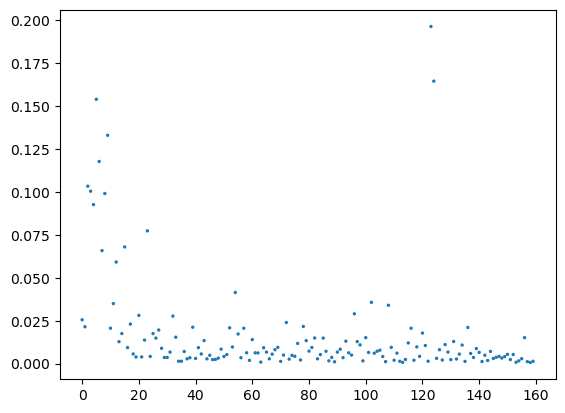

In [526]:
l = len(loss_list)
x_axis = range(l)
size = [2 for i in range(l)]
plt.scatter(x_axis,loss_list[0:l],s=size)
plt.show()


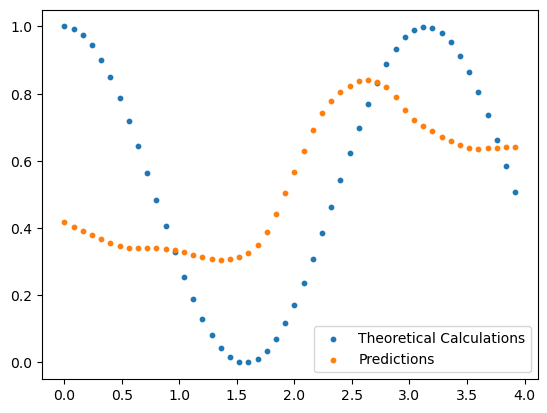

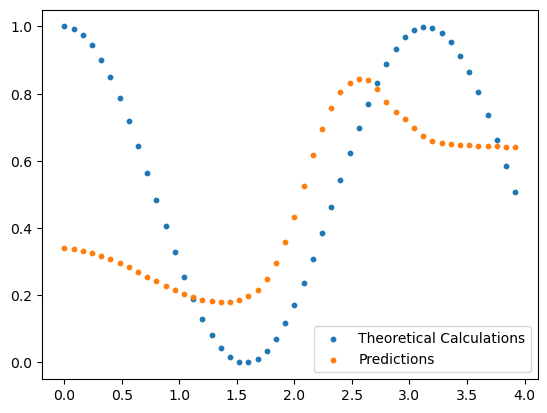

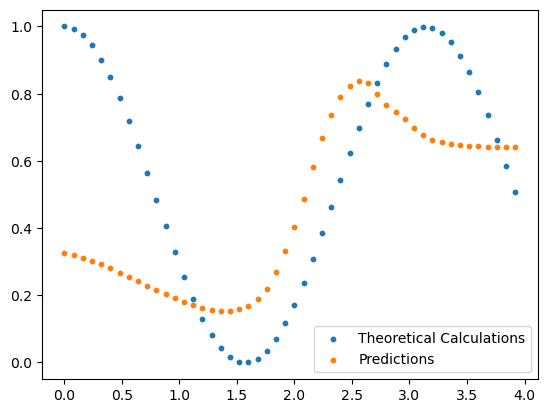

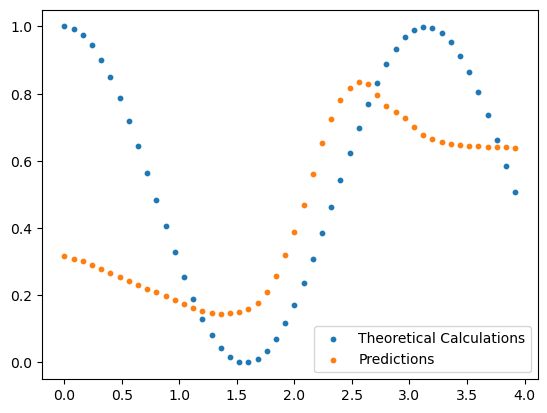

In [546]:
for Ecm in [300, 800, 1500, 2000]:
    ang = [0.08*i for i in range(50)]
    amp_theo = []
    node_feat = []
    edge_feat = []
    for i in range(50):
        graph = PairAnnihilation(Ecm, 'electron','muon',ang[i])
        amp_theo.append(graph.get_amp())
        node_feat.append(graph.get_node())
        edge_feat.append(graph.get_edge())
    node_feat = torch.cat(node_feat,dim=0).view(50,5,7)
    edge_feat = torch.cat(edge_feat,dim=0).view(50,6,2)
    amp_pred = model(node_feat, edge_feat,edge_index_list['PairAnnihilation']).view(50).tolist()
    _,_,amp_theo=normalization(amp_theo)
    plt.scatter(ang,amp_theo,label='Theoretical Calculations',s=10)
    plt.scatter(ang,amp_pred,label='Predictions',s=10)
    plt.legend()
    plt.show()


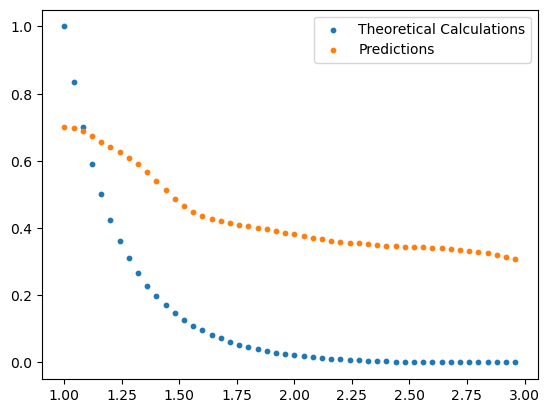

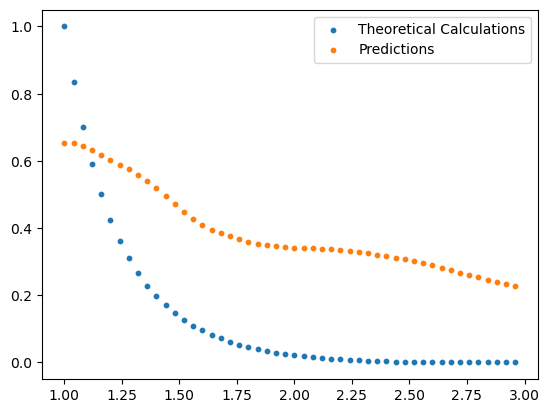

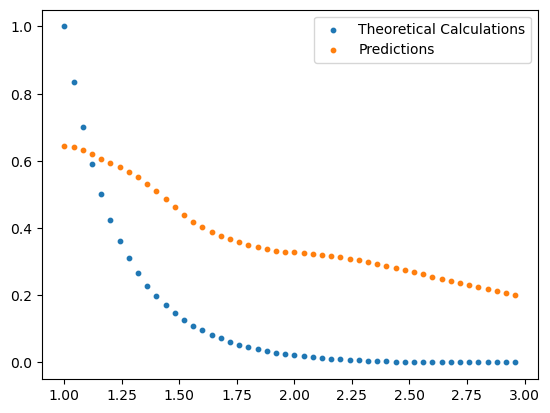

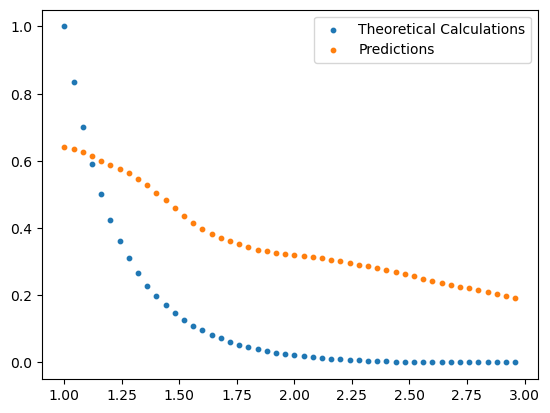

In [547]:
for Ecm in [300, 800, 1500, 2000]:
    ang = [1+0.04*i for i in range(50)]
    amp_theo = []
    node_feat = []
    edge_feat = []
    for i in range(50):
        graph = BhabhaScattering(Ecm, 'electron',ang[i])
        amp_theo.append(graph.get_amp())
        node_feat.append(graph.get_node())
        edge_feat.append(graph.get_edge())
    node_feat = torch.cat(node_feat,dim=0).view(50,5,7)
    edge_feat = torch.cat(edge_feat,dim=0).view(50,8,2)
    amp_pred = model(node_feat, edge_feat,edge_index_list['BhabhaScattering'] ).view(50).tolist()
    _,_,amp_theo=normalization(amp_theo)

    plt.scatter(ang,amp_theo,label='Theoretical Calculations',s=10)
    plt.scatter(ang,amp_pred,label='Predictions',s=10)
    plt.legend()
    plt.show()

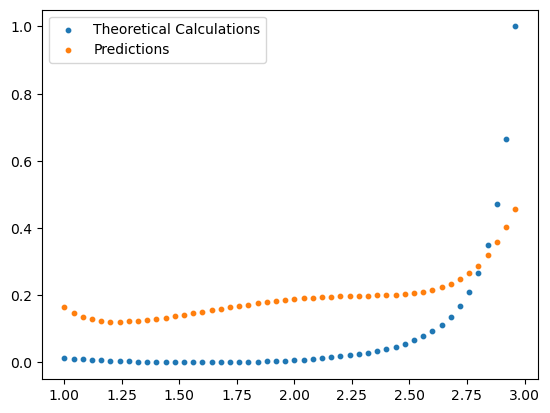

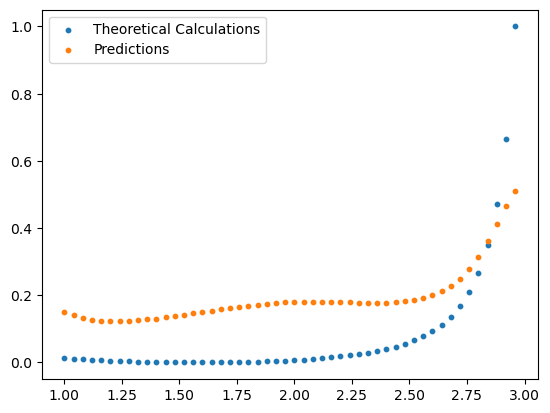

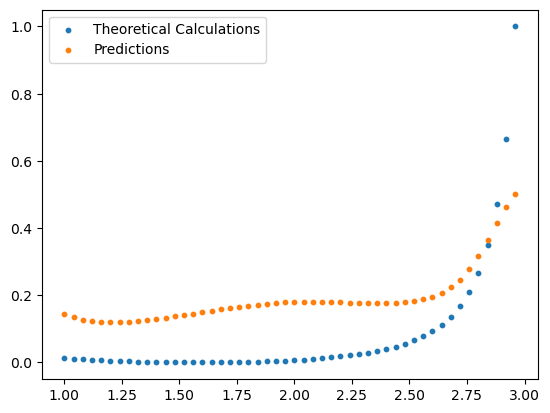

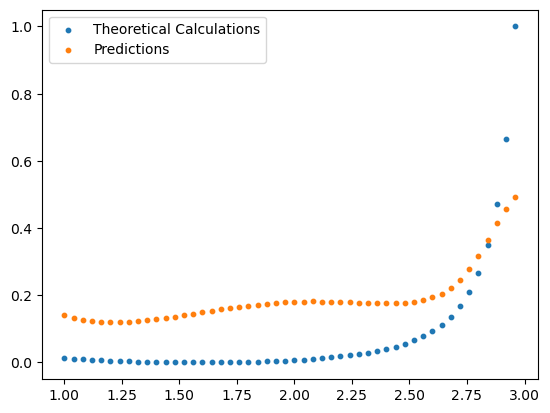

In [548]:
for Ecm in [300, 800, 1500, 2000]:
    ang = [1+0.04*i for i in range(50)]
    amp_theo = []
    node_feat = []
    edge_feat = []
    for i in range(50):
        graph = MøllerScattering(Ecm, 'electron',-1,ang[i])
        amp_theo.append(graph.get_amp())
        node_feat.append(graph.get_node())
        edge_feat.append(graph.get_edge())
    node_feat = torch.cat(node_feat,dim=0).view(50,5,7)
    edge_feat = torch.cat(edge_feat,dim=0).view(50,8,2)
    amp_pred = model(node_feat, edge_feat,edge_index_list['MøllerScattering'] ).view(50).tolist()
    size = [10 for i in range(50)]
    _,_,amp_theo=normalization(amp_theo)

    plt.scatter(ang,amp_theo,label='Theoretical Calculations',s=10)
    plt.scatter(ang,amp_pred,label='Predictions',s=10)
    plt.legend()
    plt.show()

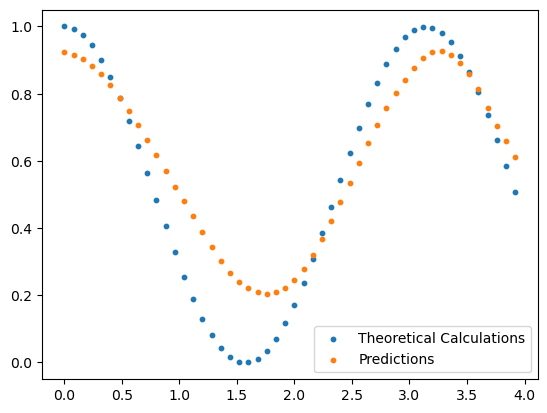

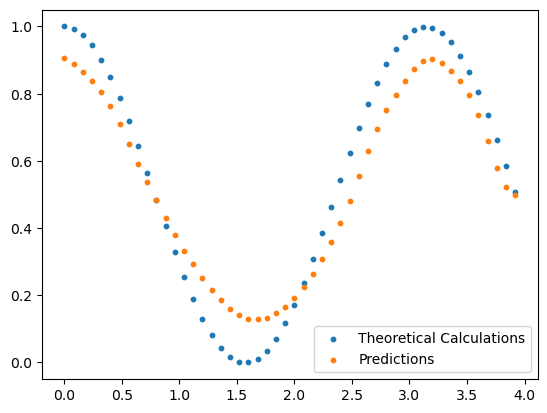

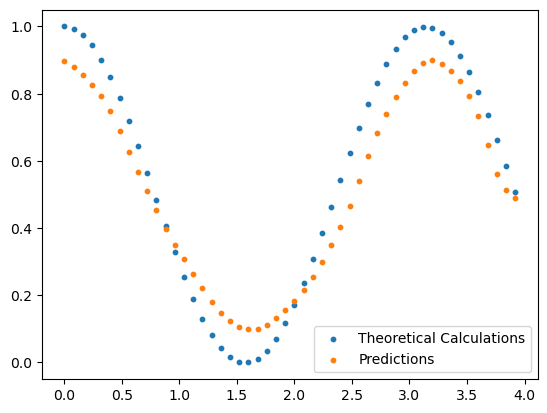

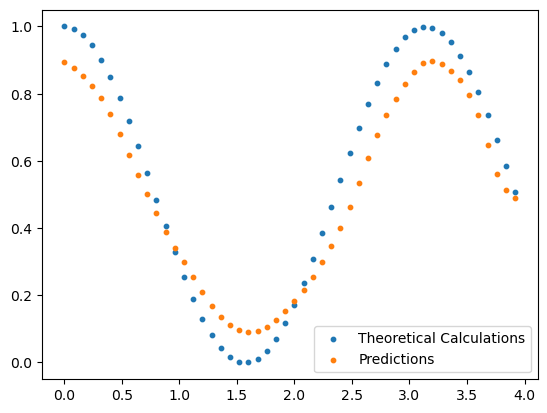

In [549]:
for Ecm in [300, 800, 1500, 2000]:
    ang = [0.08*i for i in range(50)]
    amp_theo = []
    node_feat = []
    edge_feat = []
    for i in range(50):
        graph = ColumbScattering(Ecm, -1,ang[i])
        amp_theo.append(graph.get_amp())
        node_feat.append(graph.get_node())
        edge_feat.append(graph.get_edge())
    node_feat = torch.cat(node_feat,dim=0).view(50,5,7)
    edge_feat = torch.cat(edge_feat,dim=0).view(50,6,2)
    amp_pred = model(node_feat, edge_feat,edge_index_list['ColumbScattering'] ).view(50).tolist()
    _,_,amp_theo=normalization(amp_theo)

    plt.scatter(ang,amp_theo,label='Theoretical Calculations',s=10)
    plt.scatter(ang,amp_pred,label='Predictions',s=10)
    plt.legend()
    plt.show()